In [1]:
%matplotlib tk
import json
import os
import re
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ray
from itertools import count
from tqdm import tqdm

from rl_trading.singleton import Singleton
from rl_trading.simulation.env import StockExchangeEnv0
from rl_trading.data.indicators import *
from rl_trading.utils import load_model

state_config = {
        'market_state': ['vwap'],
        'technical_indicators': [
            (RPC, {}, '1min'),
            (EMA, dict(timeperiod=5, normalize=True), '1min'),
            (EMA, dict(timeperiod=13, normalize=True), '1min'),
            (RSI, dict(timeperiod=7, normalize=True), '1min'),
            (BBANDS, dict(timeperiod=10), '1min'),
            (EMA, dict(timeperiod=20, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1h'),
            (RSI, dict(timeperiod=14, normalize=True), '1h'),
            (BBANDS, dict(timeperiod=20), '1h'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1d'),
            (EMA, dict(timeperiod=200, normalize=True), '1d'),
            (RSI, dict(timeperiod=14, normalize=True), '1d'),
            (BBANDS, dict(timeperiod=20), '1d'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1d'),
        ]}

Singleton._instances = {}
env = StockExchangeEnv0(state_config=state_config)
padding = env.padding

root_dir = '../exp_results/long_exp'
train_data = pd.read_hdf('../data/binance_BTC_USDT.h5')
eval_data = pd.read_hdf('../data/binance_BTC_USDT_new.h5')
eval_data = eval_data.loc[train_data.index[-1] - padding * 60:]
eval_data.to_hdf('../data/evaluation_data.h5', 'data')

Singleton._instances = {}

# No fees

In [ ]:
eval_env = StockExchangeEnv0(data_file_path='../data/evaluation_data.h5',
                             state_config=state_config,
                             sim_config={'max_steps': len(eval_data) - padding + 150})

model = load_model('/home/fassty/Devel/school/diploma_thesis/code/exp_results/long_exp/R2D2/R2D2_20M/R2D2_StockExchangeEnv-v0_041bd_00000_0_maker_fee=0_2023-06-18_16-11-35/checkpoint_000150')

state, _ = eval_env.reset()
done = False
rnn_state = [np.zeros([256], np.float32) for _ in range(2)]
prev_action, prev_reward = 0, 0
balance = 10_000
daily_pnls = []
for i in tqdm(range(10 * 1440), total=eval_env.max_steps):
    if i % 1440 == 0:
        if i != 0:
            current_balance = eval_env.balance_history[-1]
            daily_pnls.append(current_balance / balance - 1)
            balance = current_balance
        eval_env.render()
    action, rnn_state, _ = model.compute_single_action(state, state=rnn_state, prev_action=prev_action, prev_reward=prev_reward)
    state, prev_reward, done, *_ = eval_env.step(action)
    prev_action = action
    if done:
        break
del model
%matplotlib inline
plt.show()
%matplotlib tk

print(f'Average daily PnL: {np.mean(daily_pnls) * 100:.2f}%\tMin: {np.min(daily_pnls) * 100:.2f}%\tMax: {np.max(daily_pnls) * 100:.2f}%')

# Fee 1e-4

2023-06-19 10:42:24,966	WARNING algorithm_config.py:643 -- Cannot create R2D2Config from given `config_dict`! Property __stdout_file__ not supported.
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(s

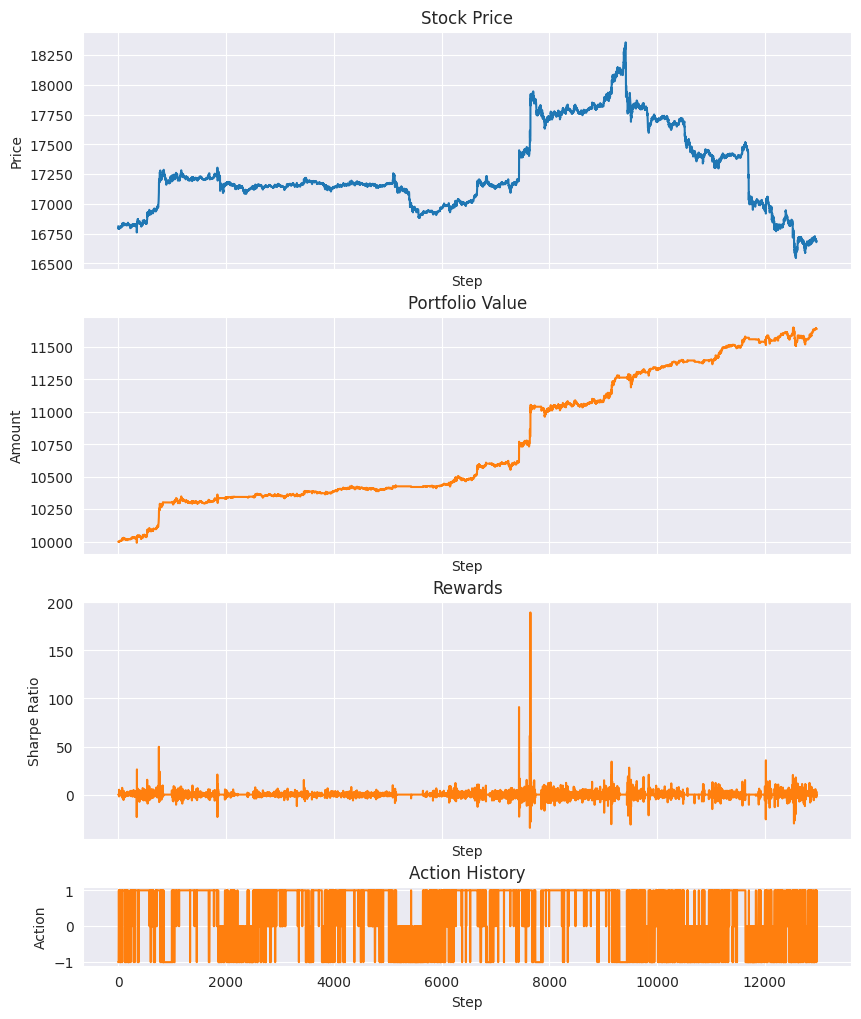

Average daily PnL: 1.71%	Min: 0.12%	Max: 4.22%


In [2]:
eval_env = StockExchangeEnv0(data_file_path='../data/evaluation_data.h5',
                             state_config=state_config,
                             exchange_config={'maker_fee':1e-4},
                             sim_config={'max_steps': len(eval_data) - padding + 150})

model = load_model('/home/fassty/Devel/school/diploma_thesis/code/exp_results/long_exp/R2D2/R2D2_20M/R2D2_StockExchangeEnv-v0_041bd_00001_1_maker_fee=0.0001_2023-06-18_16-11-35/checkpoint_000150')

state, _ = eval_env.reset()
done = False
rnn_state = [np.zeros([256], np.float32) for _ in range(2)]
prev_action, prev_reward = 0, 0
balance = 10_000
daily_pnls = []
for i in tqdm(range(10 * 1440), total=eval_env.max_steps):
    if i % 1440 == 0:
        if i != 0:
            current_balance = eval_env.balance_history[-1]
            daily_pnls.append(current_balance / balance - 1)
            balance = current_balance
        eval_env.render()
    action, rnn_state, _ = model.compute_single_action(state, state=rnn_state, prev_action=prev_action, prev_reward=prev_reward)
    state, prev_reward, done, *_ = eval_env.step(action)
    prev_action = action
    if done:
        break
del model
%matplotlib inline
plt.show()
%matplotlib tk
print(f'Average daily PnL: {np.mean(daily_pnls) * 100:.2f}%\tMin: {np.min(daily_pnls) * 100:.2f}%\tMax: {np.max(daily_pnls) * 100:.2f}%')

# Fee 5e-4

/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprec

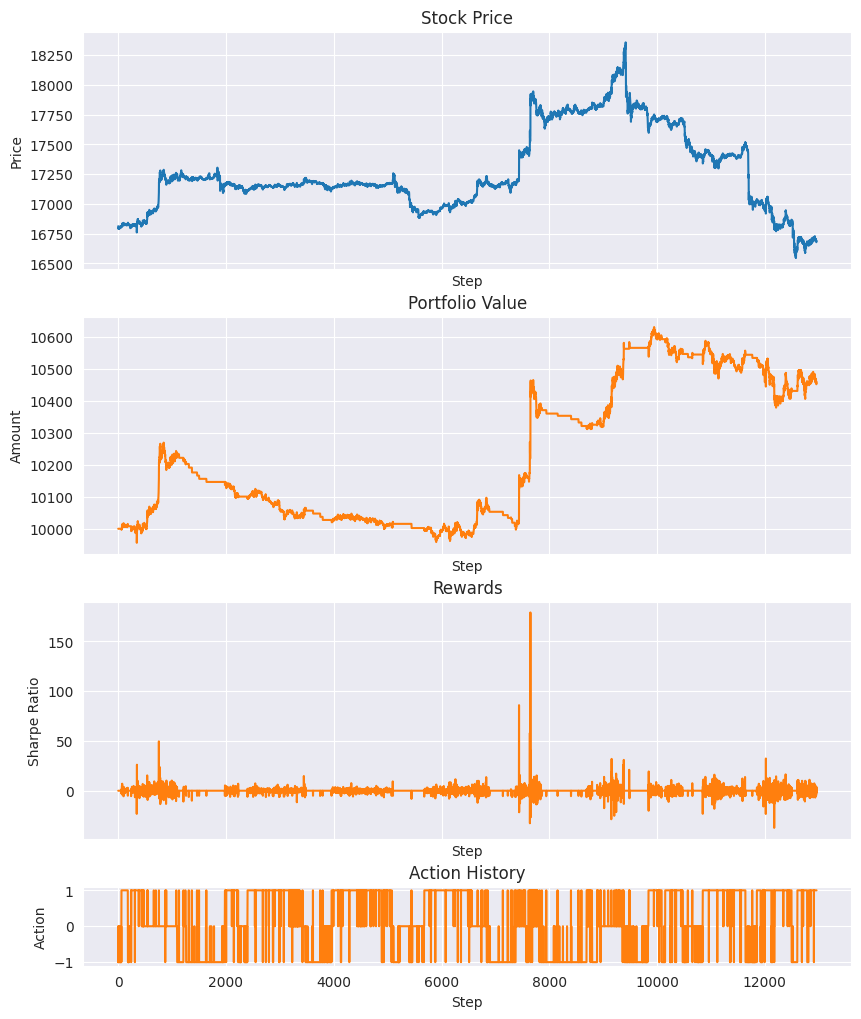

Average daily PnL: 0.51%	Min: -1.01%	Max: 2.77%


In [3]:
eval_env = StockExchangeEnv0(data_file_path='../data/evaluation_data.h5',
                             state_config=state_config,
                             exchange_config={'maker_fee':5e-4},
                             sim_config={'max_steps': len(eval_data) - padding + 150})

model = load_model('/home/fassty/Devel/school/diploma_thesis/code/exp_results/long_exp/R2D2/R2D2_20M/R2D2_StockExchangeEnv-v0_041bd_00002_2_maker_fee=0.0005_2023-06-18_16-11-35/checkpoint_000150')

state, _ = eval_env.reset()
done = False
rnn_state = [np.zeros([256], np.float32) for _ in range(2)]
prev_action, prev_reward = 0, 0
balance = 10_000
daily_pnls = []
for i in tqdm(range(10 * 1440), total=eval_env.max_steps):
    if i % 1440 == 0:
        if i != 0:
            current_balance = eval_env.balance_history[-1]
            daily_pnls.append(current_balance / balance - 1)
            balance = current_balance
        eval_env.render()
    action, rnn_state, _ = model.compute_single_action(state, state=rnn_state, prev_action=prev_action, prev_reward=prev_reward)
    state, prev_reward, done, *_ = eval_env.step(action)
    prev_action = action
    if done:
        break
del model
%matplotlib inline
plt.show()
%matplotlib tk
print(f'Average daily PnL: {np.mean(daily_pnls) * 100:.2f}%\tMin: {np.min(daily_pnls) * 100:.2f}%\tMax: {np.max(daily_pnls) * 100:.2f}%')

# Fee 1e-3

2023-06-19 11:51:49,775	WARNING algorithm_config.py:643 -- Cannot create R2D2Config from given `config_dict`! Property __stdout_file__ not supported.
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(s

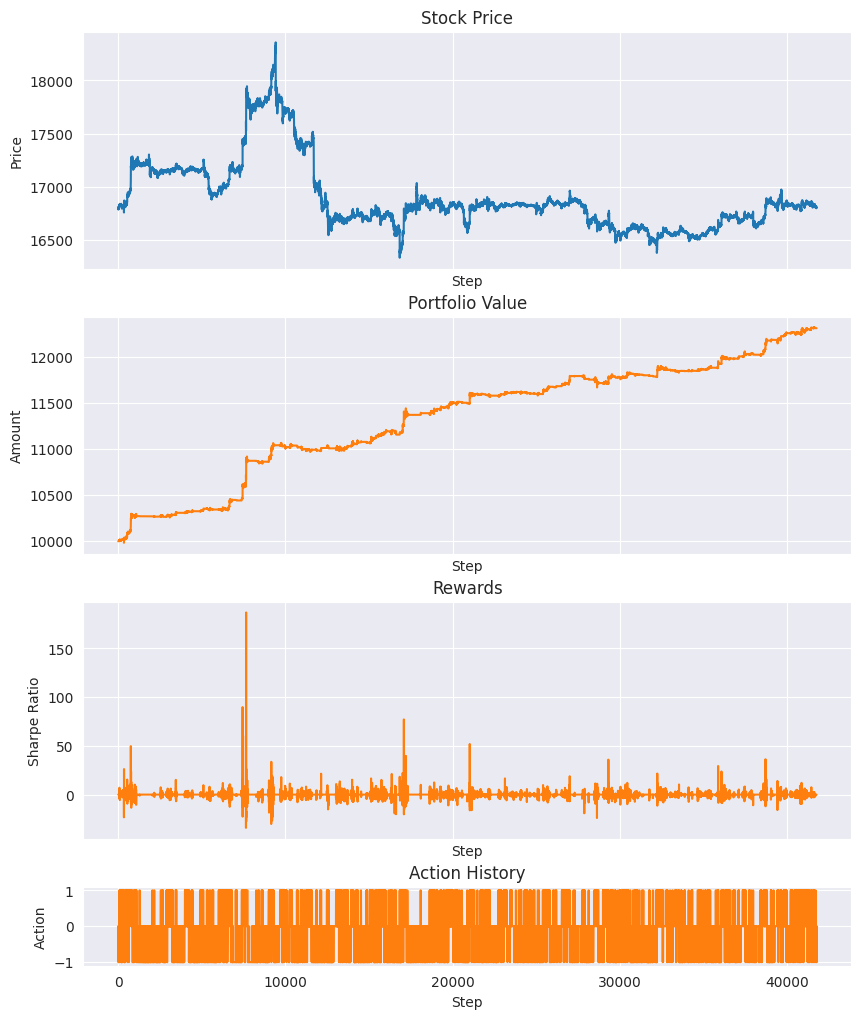

Average daily PnL: 0.72%	Min: -0.64%	Max: 4.03%


In [2]:
eval_env = StockExchangeEnv0(data_file_path='../data/evaluation_data.h5',
                             state_config=state_config,
                             exchange_config={'maker_fee':1e-4},
                             sim_config={'max_steps': len(eval_data) - padding + 150})

model = load_model('/home/fassty/Devel/school/diploma_thesis/code/exp_results/long_exp/R2D2/R2D2_20M/R2D2_StockExchangeEnv-v0_041bd_00003_3_maker_fee=0.0010_2023-06-18_16-11-35/checkpoint_000150')

state, _ = eval_env.reset()
done = False
rnn_state = [np.zeros([256], np.float32) for _ in range(2)]
prev_action, prev_reward = 0, 0
balance = 10_000
daily_pnls = []
for i in tqdm(range(30 * 1440), total=30 * 1440):
    if i % 1440 == 0:
        if i != 0:
            current_balance = eval_env.balance_history[-1]
            daily_pnls.append(current_balance / balance - 1)
            balance = current_balance
        eval_env.render()
    action, rnn_state, _ = model.compute_single_action(state, state=rnn_state, prev_action=prev_action, prev_reward=prev_reward)
    state, prev_reward, done, *_ = eval_env.step(action)
    prev_action = action
    if done:
        break
del model
%matplotlib inline
plt.show()
%matplotlib tk
print(f'Average daily PnL: {np.mean(daily_pnls) * 100:.2f}%\tMin: {np.min(daily_pnls) * 100:.2f}%\tMax: {np.max(daily_pnls) * 100:.2f}%')

In [3]:
eval_env = StockExchangeEnv0(data_file_path='../data/evaluation_data.h5',
                             state_config=state_config,
                             exchange_config={'maker_fee':1e-3},
                             sim_config={'max_steps': len(eval_data) - padding + 150})

model = load_model('/home/fassty/Devel/school/diploma_thesis/code/exp_results/long_exp/SAC/SAC_20M/SAC_StockExchangeEnv-v0_06976_00003_3_maker_fee=0.0010_2023-06-18_16-11-38/checkpoint_000150')

state, _ = eval_env.reset()
done = False
balance = 10_000
daily_pnls = []
for i in tqdm(range(30 * 1440), total=30 * 1440):
    if i % 1440 == 0:
        if i != 0:
            current_balance = eval_env.balance_history[-1]
            daily_pnls.append(current_balance / balance - 1)
            balance = current_balance
        eval_env.render()
    action = model.compute_single_action(state)
    state, reward, done, *_ = eval_env.step(action)
    if done:
        break
del model
%matplotlib inline
plt.show()
%matplotlib tk
print(f'Average daily PnL: {np.mean(daily_pnls) * 100:.2f}%\tMin: {np.min(daily_pnls) * 100:.2f}%\tMax: {np.max(daily_pnls) * 100:.2f}%')

2023-06-19 11:47:25,676	WARNING algorithm_config.py:643 -- Cannot create SACConfig from given `config_dict`! Property __stdout_file__ not supported.
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(se

KeyboardInterrupt: 

In [5]:
del model